In [ ]:
import numpy as np
import pandas as pd
import os

import talib as ta
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

from scipy import stats
import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs

import tushare as ts
# 设置tushare token (请替换为您的token)
# 方法1: 直接设置
ts.set_token('tushare_token_here')

# 方法2: 从环境变量读取
#ts.set_token(os.environ.get('TUSHARE_TOKEN'))

# 初始化pro接口
pro = ts.pro_api()

sd = '2025-01-01'
ed = '2026-02-22'


In [20]:
# 获取ETF基金列表
def get_etf_list():
    """
    获取场内基金(ETF)列表
    market='E' 表示场内基金
    """
    df = pro.etf_basic(list_status='L', fields='ts_code,extname,index_code,index_name,exchange,mgr_name,etf_type')

    # 筛选ETF基金
    #etf_df = df 
    etf_df = df[ df['etf_type'] == 'QDII' ]

    #etf_df = df[ (df['extname'] == '沪深300ETF嘉实') & (df['index_code'] == '000300.SH') & (df['exchange'] == 'SZ') & (df['mgr_name'] == '嘉实基金')]
    #etf_df = df[ (df['extname'] == '沪深300ETF嘉实') & (df['index_code'] == '000300.SH') & (df['exchange'] == 'SZ')]
    return etf_df

# 获取ETF列表
etf_list = get_etf_list()

print(f"共有 {len(etf_list)} 只ETF基金")
print(f"数据形状: {etf_list.shape}")
etf_list.head()



共有 86 只ETF基金
数据形状: (86, 7)


,ts_code,extname,index_code,index_name,exchange,mgr_name,etf_type
3,159100.SZ,巴西ETF,BOVESPA.OTH,巴西IBOVESPA指数,SZ,华夏基金,QDII
55,159202.SZ,恒生互联网ETF万家,HSIII.HI,恒生互联网科技业指数,SZ,万家基金,QDII
143,159303.SZ,恒生医疗ETF大成,HSHCI.HI,恒生医疗保健指数,SZ,大成基金,QDII
162,159329.SZ,沙特ETF南方,FISAULM.OTH,富时沙特阿拉伯指数,SZ,南方基金,QDII
219,159501.SZ,纳指ETF嘉实,NDX.NASDAQ,纳斯达克100指数,SZ,嘉实基金,QDII


In [21]:
# 获取ETF在初始日期前10个交易日的平均交易金额，并按降序排序
def get_etf_avg_amount(etf_list, start_date):
    """
    获取ETF在初始日期前10个交易日的平均交易金额
    
    参数:
        etf_list: ETF列表DataFrame，包含ts_code列
        start_date: 初始日期，格式'YYYY-MM-DD'
    
    返回:
        包含平均交易金额信息的DataFrame，按降序排序
    """
    import time
    
    # 将日期格式转换为YYYYMMDD
    start_date_str = start_date.replace('-', '')
    
    result_list = []
    
    print(f"正在获取{len(etf_list)}只ETF的前10个交易日交易金额数据...")
    
    for idx, row in etf_list.iterrows():
        ts_code = row['ts_code']
        try:
            # 获取初始日期之前的数据，取最近的10个交易日
            # 为了确保有足够的数据，我们获取初始日期前60天的数据
            from datetime import datetime, timedelta
            start_dt = datetime.strptime(start_date, '%Y-%m-%d')
            before_date = (start_dt - timedelta(days=60)).strftime('%Y%m%d')
            
            df = pro.fund_daily(
                ts_code=ts_code, 
                start_date=before_date, 
                end_date=start_date_str,
                fields='ts_code,trade_date,amount'
            )
            
            if df is not None and not df.empty:
                # 按交易日期降序排序，取最近10个交易日
                df = df.sort_values('trade_date', ascending=False).head(10)
                
                # 计算平均交易金额（排除空值）
                avg_amount = df['amount'].mean()
                
                result_list.append({
                    'ts_code': ts_code,
                    'extname': row['extname'],
                    'index_name': row['index_name'],
                    'exchange': row['exchange'],
                    'mgr_name': row['mgr_name'],
                    'etf_type': row['etf_type'],
                    'avg_amount_10d': avg_amount,  # 前10日平均成交额（千元）
                    'avg_amount_10d_万元': avg_amount / 10,  # 转换为万元
                    'trading_days': len(df)  # 实际交易日天数
                })
            else:
                # 没有数据的ETF也记录下来
                result_list.append({
                    'ts_code': ts_code,
                    'extname': row['extname'],
                    'index_name': row['index_name'],
                    'exchange': row['exchange'],
                    'mgr_name': row['mgr_name'],
                    'etf_type': row['etf_type'],
                    'avg_amount_10d': 0,
                    'avg_amount_10d_万元': 0,
                    'trading_days': 0
                })
            
            # 控制请求频率，避免超过API限制
            time.sleep(0.2)
            
            if (idx + 1) % 10 == 0:
                print(f"已处理 {idx + 1}/{len(etf_list)} 只ETF")
                
        except Exception as e:
            print(f"获取 {ts_code} 数据时出错: {str(e)}")
            result_list.append({
                'ts_code': ts_code,
                'extname': row['extname'],
                'index_name': row['index_name'],
                'exchange': row['exchange'],
                'mgr_name': row['mgr_name'],
                'etf_type': row['etf_type'],
                'avg_amount_10d': 0,
                'avg_amount_10d_万元': 0,
                'trading_days': 0
            })
    
    # 创建结果DataFrame
    result_df = pd.DataFrame(result_list)
    
    # 按平均交易金额降序排序
    result_df = result_df.sort_values('avg_amount_10d', ascending=False).reset_index(drop=True)
    
    print(f"\n数据获取完成！共{len(result_df)}只ETF")
    
    return result_df

# 执行函数获取排序后的ETF列表
etf_sorted_by_amount = get_etf_avg_amount(etf_list, sd)

# 显示结果
print("\n" + "="*80)
print("ETF按初始日期前10个交易日平均交易金额降序排列:")
print("="*80)

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

# 显示前20只ETF
print("\n前20只ETF（按平均交易金额降序）：")
display_df = etf_sorted_by_amount.head(20).copy()
display_df.index = range(1, len(display_df) + 1)  # 从1开始编号
#print(display_df.to_string())
print(f"数据形状: {display_df.shape}")
etf_sorted_by_amount.head()

# 显示完整列表的统计信息
print(f"\n统计信息:")
print(f"总ETF数量: {len(etf_sorted_by_amount)}")
print(f"有交易数据的ETF: {(etf_sorted_by_amount['trading_days'] > 0).sum()}")
print(f"平均成交额（万元）统计:")
print(etf_sorted_by_amount['avg_amount_10d_万元'].describe())

# 保存排序后的完整列表保存前10行
etf_top = etf_sorted_by_amount.head(10)

print(f"数据形状: {etf_top.shape}")
etf_top.head()

正在获取86只ETF的前10个交易日交易金额数据...
已处理 220/86 只ETF
已处理 230/86 只ETF
已处理 330/86 只ETF
已处理 420/86 只ETF
已处理 780/86 只ETF
已处理 790/86 只ETF
已处理 800/86 只ETF
已处理 810/86 只ETF
已处理 830/86 只ETF
已处理 1030/86 只ETF

数据获取完成！共86只ETF

ETF按初始日期前10个交易日平均交易金额降序排列:

前20只ETF（按平均交易金额降序）：
数据形状: (20, 9)

统计信息:
总ETF数量: 86
有交易数据的ETF: 79
平均成交额（万元）统计:
count        86.000000
mean      31360.811053
std       48931.409860
min           0.000000
25%        2623.177068
50%        9142.262570
75%       40098.413782
max      236712.438580
Name: avg_amount_10d_万元, dtype: float64
数据形状: (10, 9)


,ts_code,extname,index_name,exchange,mgr_name,etf_type,avg_amount_10d,avg_amount_10d_万元,trading_days
0,513180.SH,恒生科技指数ETF,恒生科技指数,SH,华夏基金,QDII,2.367124e+06,236712.43858,10
1,513130.SH,恒生科技ETF,恒生科技指数,SH,华泰柏瑞基金,QDII,2.079340e+06,207934.01991,10
2,513330.SH,恒生互联网ETF,恒生互联网科技业指数,SH,华夏基金,QDII,1.759704e+06,175970.37229,10
3,159529.SZ,标普消费ETF,标普500消费精选指数,SZ,景顺长城基金,QDII,1.611777e+06,161177.65077,10
4,159941.SZ,纳指ETF,纳斯达克100指数,SZ,广发基金,QDII,1.524025e+06,152402.54845,10


In [22]:
#获取ETF的份额和规模情况
"""
#单位净值total_share	累计净值total_size

#获取”沪深300ETF华夏”ETF2025年以来每个交易日的份额和规模情况
df = pro.etf_share_size(ts_code='510330.SH', start_date='20250101', end_date='20251224')

#获取2025年12月24日上交所的所有ETF份额和规模情况
df = pro.etf_share_size(trade_date='20251224', exchange='SSE')
"""
def get_etf_share_size(etf_codes):
    """
    获取ETF的份额和规模情况
    etf_codes: ETF代码列表
    """
    df_list = []
    for code in etf_codes:
        df = pro.etf_share_size(ts_code=code, start_date='20250101',)
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)
    

#etf_size_list = get_etf_share_size(etf_codes=etf_list['ts_code'].tolist())

#print(f"共有 {len(etf_size_list)} 只ETF基金")
#print(f"数据形状: {etf_size_list.shape}")
#etf_size_list.head()

In [23]:
# 获取ETF日线行情数据
def get_etf_daily(ts_code, start_date=None, end_date=None):
    """
    获取ETF日线行情数据
    
    参数:
        ts_code: ETF代码，如 '510300.SH' (沪深300ETF)
        start_date: 开始日期，格式 'YYYYMMDD'
        end_date: 结束日期，格式 'YYYYMMDD'
    
    返回字段:
        ts_code: 基金代码
        trade_date: 交易日期
        open: 开盘价(元)
        high: 最高价(元)
        low: 最低价(元)
        close: 收盘价(元)
        pre_close: 昨收价(元)
        change: 涨跌额(元)
        pct_chg: 涨跌幅(%)
        vol: 成交量(手)
        amount: 成交额(千元)
    """
    df = pro.fund_daily(ts_code=ts_code, start_date=start_date, end_date=end_date)
    if df is not None and not df.empty:
        df = df.sort_values('trade_date')
        df.set_index('trade_date', inplace=True)
    return df

In [24]:
def get_multiple_etf_data(etf_codes, start_date, end_date):
    """
    获取多只ETF的历史收盘价数据
    
    参数:
        etf_codes: ETF代码列表 或 字典{代码: 名称}
        start_date: 开始日期
        end_date: 结束日期
    
    返回:
        DataFrame: 各ETF的收盘价数据
    """
    if isinstance(etf_codes, dict):
        codes = list(etf_codes.keys())
    else:
        codes = etf_codes
    
    all_data = {}
    for code in codes:
        df = pro.fund_daily(ts_code=code, start_date=start_date, end_date=end_date)
        if df is not None and not df.empty:
            df = df.sort_values('trade_date')
            df.set_index('trade_date', inplace=True)
            all_data[code] = df['close']
    
    # 合并为DataFrame
    result = pd.DataFrame(all_data)
    return result

In [25]:
# 常用ETF代码
"""
etf_codes = {
    '510300.SH': '沪深300ETF',
    '510500.SH': '中证500ETF', 
    '510050.SH': '上证50ETF',
    '159919.SZ': '沪深300ETF(深)',
    '159915.SZ': '创业板ETF',
    '518880.SH': '黄金ETF',
    '513100.SH': '纳指ETF',
    '159920.SZ': '恒生ETF',
}
"""

etf_codes = etf_top['ts_code'].tolist()  # 从前10只ETF中提取代码列表

# 获取多只ETF的历史数据
data = get_multiple_etf_data(etf_codes, sd, ed)
print(f"数据形状: {data.shape}")
data.head()

数据形状: (243, 10)


,513180.SH,513130.SH,513330.SH,159529.SZ,159941.SZ,513050.SH,159509.SZ,513100.SH,513300.SH,159659.SZ
trade_date,,,,,,,,,,
20250102,0.602,0.588,0.411,1.547,1.246,1.162,1.632,1.643,2.105,1.739
20250103,0.605,0.589,0.410,1.470,1.240,1.166,1.621,1.633,2.094,1.721
20250106,0.608,0.591,0.410,1.617,1.274,1.165,1.660,1.669,2.151,1.769
20250107,0.600,0.583,0.404,1.645,1.264,1.124,1.661,1.659,2.125,1.747
20250108,0.597,0.580,0.403,1.726,1.257,1.118,1.649,1.642,2.111,1.731


In [26]:
# 计算日收益率（用于投资组合优化）
returns = data.pct_change().dropna()
print("日收益率统计:")
print(returns.describe())

# 计算年化收益率和波动率
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * (252 ** 0.5)

summary = pd.DataFrame({
    '年化收益率': annual_returns,
    '年化波动率': annual_volatility,
    '夏普比率': annual_returns / annual_volatility
})
summary

日收益率统计:
        513180.SH   513130.SH   513330.SH   159529.SZ   159941.SZ   513050.SH  \
count  242.000000  242.000000  242.000000  242.000000  242.000000  242.000000   
mean     0.000983    0.001001    0.001141   -0.000137    0.000637    0.001150   
std      0.018676    0.018691    0.020042    0.026931    0.015267    0.019306   
min     -0.099591   -0.099440   -0.100402   -0.100206   -0.099531   -0.099930   
25%     -0.010957   -0.012104   -0.010372   -0.008389   -0.005711   -0.011130   
50%      0.001337    0.001399    0.000000   -0.000717    0.000343    0.000801   
75%      0.011677    0.011872    0.012590    0.005411    0.007912    0.011235   
max      0.053915    0.053316    0.079304    0.100353    0.092012    0.061362   

        159509.SZ   513100.SH   513300.SH   159659.SZ  
count  242.000000  242.000000  242.000000  242.000000  
mean     0.001561    0.000727    0.000503    0.000664  
std      0.017920    0.015358    0.015432    0.015463  
min     -0.100219   -0.099788   -0.099

C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\4228874854.py:2: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



,年化收益率,年化波动率,夏普比率
513180.SH,0.247717,0.296466,0.835566
513130.SH,0.252189,0.296703,0.849971
513330.SH,0.287526,0.318159,0.903718
159529.SZ,-0.034543,0.427518,-0.080799
159941.SZ,0.160400,0.242361,0.661823
513050.SH,0.289720,0.306477,0.945323
159509.SZ,0.393369,0.284470,1.382812
513100.SH,0.183259,0.243809,0.751650
513300.SH,0.126746,0.244968,0.517396
159659.SZ,0.167347,0.245463,0.681759


In [27]:
date = data.index
#将第一行的数据乘以100，得到一个新的收益值Series  
newdata = (data/data.iloc[0, :])*100
 
stocks = list(newdata.columns) #获取列名列表

def trace(df, date, stock):
    return go.Scatter(x = date, #横坐标日期
                      y = df[stock],
                      name=stock)#纵坐标为股价与（2016年10月24日）的比值
    

data = [trace(newdata,date,stock) for stock in stocks]
 
#print(data)
iplot(data)

In [28]:
log_returns = np.log(newdata.pct_change()+1)
log_returns = log_returns.dropna()
log_returns.mean()*252

def normality_test(array):
    print('Norm test p-value %14.3f' % scs.normaltest(array)[1])

for stock in stocks:
    print('\nResults for {}'.format(stock))
    print('-'*32)
    log_data = np.array(log_returns[stock])
    normality_test(log_data)


Results for 513180.SH
--------------------------------
Norm test p-value          0.000

Results for 513130.SH
--------------------------------
Norm test p-value          0.000

Results for 513330.SH
--------------------------------
Norm test p-value          0.000

Results for 159529.SZ
--------------------------------
Norm test p-value          0.000

Results for 159941.SZ
--------------------------------
Norm test p-value          0.000

Results for 513050.SH
--------------------------------
Norm test p-value          0.000

Results for 159509.SZ
--------------------------------
Norm test p-value          0.000

Results for 513100.SH
--------------------------------
Norm test p-value          0.000

Results for 513300.SH
--------------------------------
Norm test p-value          0.000

Results for 159659.SZ
--------------------------------
Norm test p-value          0.000


C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\1640247155.py:1: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



10


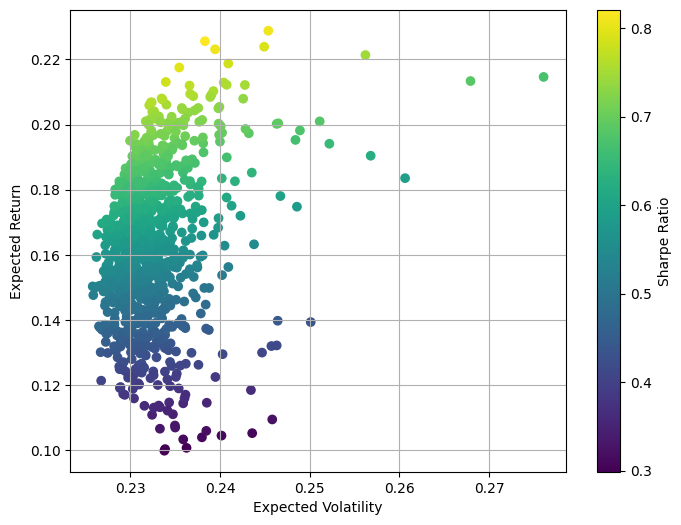

In [29]:
sn = len(stocks) #组合的标的股票数量
print(sn)

weights = np.random.random(sn)
weights /= np.sum(weights)
weights

np.dot(weights, log_returns.mean())*252
np.dot(weights, np.dot(log_returns.cov()*252, weights))

np.sqrt(np.dot(weights, np.dot(log_returns.cov()*252, weights)))

port_returns = []
port_variance = []
for p in range(1000):
    weights = np.random.random(sn)
    weights /=np.sum(weights)
    port_returns.append(np.sum(log_returns.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

#无风险利率设定为3%
risk_free = 0.03
plt.figure(figsize=(8, 6))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label = 'Sharpe Ratio')

In [30]:
#夏普比率最大

def stats(weights):
    weights = np.array(weights)
    port_returns = np.sum(log_returns.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

#最小化夏普指数的负值
def min_sharpe(weights):
    return -stats(weights)[2]

#给定初始权重
x0 = sn*[1./sn]

#权重（某股票持仓比例）限制在0和1之间。
bnds = tuple((0,1) for x in range(sn))

#权重（股票持仓比例）的总和为1。
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
#print(cons)

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe,
                    x0, 
                    method = 'SLSQP', 
                    bounds = bnds, 
                    constraints = cons)
opts

opts['x'].round(3)
stats(opts['x']).round(3)

array([0.33, 0.26, 1.27])

In [31]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return stats(weights)[1]
#print(cons)
optv = sco.minimize(min_variance, 
                    x0, 
                    method = 'SLSQP', 
                    bounds = bnds, 
                    constraints = cons)
optv

optv['x'].round(3)
stats(optv['x']).round(3)

array([0.146, 0.224, 0.652])

In [32]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return stats(weights)[1]

#在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0,0.5,50)
target_variance = []

for tar in target_returns:
     #给定限制条件：给定收益率、投资组合权重之和为1
     
    cons = ({'type':'eq','fun':lambda x:stats(x)[0]-tar},
            {'type':'eq','fun':lambda x:np.sum(x)-1})


    res = sco.minimize(min_variance, 
                        x0, 
                        method = 'SLSQP', 
                        bounds = bnds, 
                        constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

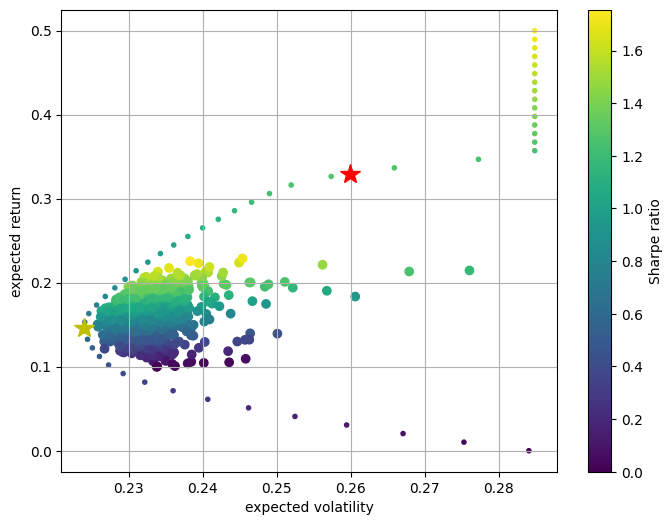


========== 方差最小投资组合 (黄星) ==========
     股票名称     权重  权重(%)
513180.SH 0.3300  33.00
159659.SZ 0.2408  24.08
513100.SH 0.2076  20.76
159941.SZ 0.1623  16.23
159529.SZ 0.0594   5.94
513130.SH 0.0000   0.00
513050.SH 0.0000   0.00
513330.SH 0.0000   0.00
159509.SZ 0.0000   0.00
513300.SH 0.0000   0.00

预期收益率: 0.1459
预期波动率: 0.2239
夏普比率: 0.6516


In [33]:
plt.figure(figsize = (8,6))
#圆点：随机生成的投资组合散布的点
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：投资组合有效边界
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = '.')


#红星：标记夏普率最大的组合点
plt.plot(stats(opts['x'])[1], stats(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记方差最小投资组合点
plt.plot(stats(optv['x'])[1], stats(optv['x'])[0], 'y*', markersize = 15.0)


plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')
plt.show()

#显示黄星标记的方差最小投资组合权重列表
print('\n========== 方差最小投资组合 (黄星) ==========')
min_var_weights = pd.DataFrame({
    '股票名称': stocks,
    '权重': optv['x'].round(4),
    '权重(%)': (optv['x'] * 100).round(2)
})
min_var_weights = min_var_weights.sort_values('权重', ascending=False)
print(min_var_weights.to_string(index=False))
print(f'\n预期收益率: {stats(optv["x"])[0]:.4f}')
print(f'预期波动率: {stats(optv["x"])[1]:.4f}')
print(f'夏普比率: {stats(optv["x"])[2]:.4f}')

In [34]:
# ========== 显示红星标记的夏普率最大组合详情 ==========
print('\n' + '='*80)
print('🌟 最大夏普比率投资组合 (红星标记)')
print('='*80)

# 创建权重数据框
max_sharpe_weights = pd.DataFrame({
    'ETF代码': stocks,
    '权重': opts['x'].round(4),
    '权重(%)': (opts['x'] * 100).round(2)
})

# 按权重降序排列
max_sharpe_weights = max_sharpe_weights.sort_values('权重', ascending=False)

# 显示权重配置
print('\n💼 各ETF权重配置 (按权重从大到小):')
print('-' * 80)

for idx, row in max_sharpe_weights.iterrows():
    etf_code = row['ETF代码']
    weight_pct = row['权重(%)']
    weight_dec = row['权重']
    
    # 只显示权重大于0.1%的ETF
    if weight_pct > 0.1:
        # 用条形图表示权重大小
        bar_length = int(weight_pct / 2)  # 每2%一个字符
        bar = '█' * bar_length
        print(f"  {etf_code:15s}  {weight_pct:6.2f}%  ({weight_dec:.4f})  {bar}")
    else:
        print(f"  {etf_code:15s}  {weight_pct:6.2f}%  ({weight_dec:.4f})")

# 显示组合表现指标
print('\n📊 组合表现指标:')
print(f'  • 预期年化收益率: {stats(opts["x"])[0]*100:.2f}%')
print(f'  • 年化波动率(风险): {stats(opts["x"])[1]*100:.2f}%')
print(f'  • 夏普比率: {stats(opts["x"])[2]:.4f}')

# 验证权重总和
print(f'\n✅ 权重总和验证: {opts["x"].sum():.6f} (应为 1.0)')
print('='*80)

# 与方差最小组合的对比
print('\n📈 与方差最小组合的对比:')
print('-' * 80)
comparison = pd.DataFrame({
    '指标': ['年化收益率(%)', '年化波动率(%)', '夏普比率'],
    '最大夏普率(红星)': [
        stats(opts['x'])[0]*100,
        stats(opts['x'])[1]*100,
        stats(opts['x'])[2]
    ],
    '最小方差(黄星)': [
        stats(optv['x'])[0]*100,
        stats(optv['x'])[1]*100,
        stats(optv['x'])[2]
    ]
})
comparison['差异'] = comparison['最大夏普率(红星)'] - comparison['最小方差(黄星)']
print(comparison.to_string(index=False))
print('='*80)



🌟 最大夏普比率投资组合 (红星标记)

💼 各ETF权重配置 (按权重从大到小):
--------------------------------------------------------------------------------
  159509.SZ         79.25%  (0.7925)  ███████████████████████████████████████
  513050.SH         20.75%  (0.2075)  ██████████
  513130.SH          0.00%  (0.0000)
  513180.SH          0.00%  (0.0000)
  159529.SZ          0.00%  (0.0000)
  513330.SH          0.00%  (0.0000)
  159941.SZ          0.00%  (0.0000)
  513100.SH          0.00%  (0.0000)
  513300.SH          0.00%  (0.0000)
  159659.SZ          0.00%  (0.0000)

📊 组合表现指标:
  • 预期年化收益率: 32.99%
  • 年化波动率(风险): 25.99%
  • 夏普比率: 1.2695

✅ 权重总和验证: 1.000000 (应为 1.0)

📈 与方差最小组合的对比:
--------------------------------------------------------------------------------
      指标  最大夏普率(红星)  最小方差(黄星)        差异
年化收益率(%)  32.991319 14.592582 18.398737
年化波动率(%)  25.987299 22.393978  3.593321
    夏普比率   1.269517  0.651630  0.617887



📈 投资组合累计收益曲线对比


C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\2868658734.py:46: UserWarning:

Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.

C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\2868658734.py:46: UserWarning:

Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.

C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\2868658734.py:46: UserWarning:

Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.

C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\2868658734.py:46: UserWarning:

Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.

C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\2868658734.py:46: UserWarning:

Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.

C:\Users\yuany\AppData\Local\Temp\ipykernel_11368\2868658734.py:46: UserWarning:

Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from font(s) DejaVu Sans.

C:\Users\yuany\AppData\Local

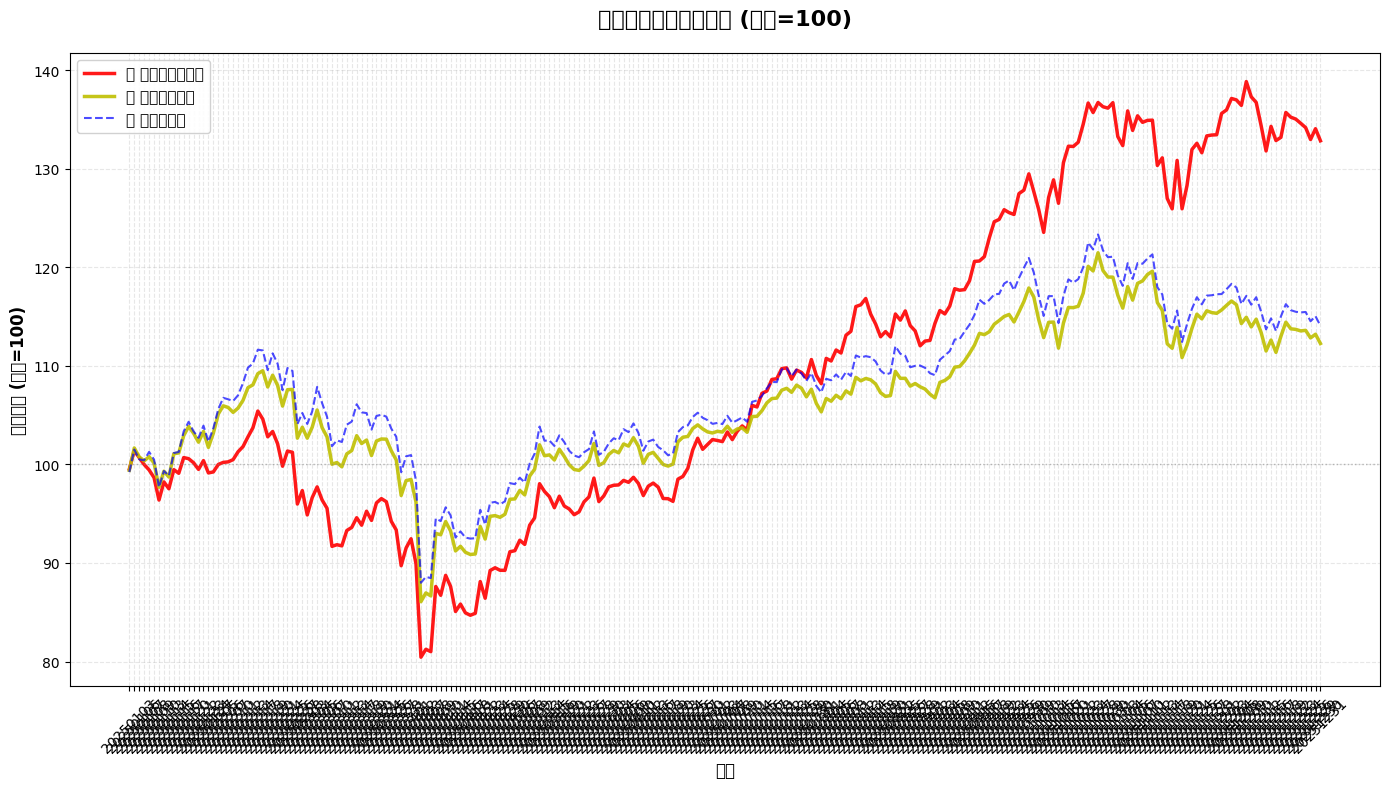


📊 累计收益统计
   组合类型  期初值        期末值  累计收益率(%)
🔴 最大夏普率  100 132.849900 32.849900
 🟡 最小方差  100 112.275023 12.275023
📊 等权重基准  100 114.068835 14.068835

📉 最大回撤分析
   组合类型    最大回撤(%)
🔴 最大夏普率 -23.695000
 🟡 最小方差 -21.400674
📊 等权重基准 -21.190466


In [35]:
# ========== 绘制最优组合的累计收益曲线 ==========
print('\n' + '='*80)
print('📈 投资组合累计收益曲线对比')
print('='*80)

# 计算最大夏普率组合的每日收益
max_sharpe_weights = opts['x']
max_sharpe_daily_returns = (log_returns * max_sharpe_weights).sum(axis=1)

# 计算最小方差组合的每日收益
min_var_weights = optv['x']
min_var_daily_returns = (log_returns * min_var_weights).sum(axis=1)

# 计算累计收益（转换为百分比）
max_sharpe_cumulative = (1 + max_sharpe_daily_returns).cumprod() * 100
min_var_cumulative = (1 + min_var_daily_returns).cumprod() * 100

# 创建等权重组合作为基准
equal_weights = np.array([1/len(stocks)] * len(stocks))
equal_daily_returns = (log_returns * equal_weights).sum(axis=1)
equal_cumulative = (1 + equal_daily_returns).cumprod() * 100

# 使用matplotlib绘制收益曲线
plt.figure(figsize=(14, 8))

# 绘制三条曲线
plt.plot(max_sharpe_cumulative.index, max_sharpe_cumulative.values, 
         'r-', linewidth=2.5, label='🔴 最大夏普率组合', alpha=0.9)
plt.plot(min_var_cumulative.index, min_var_cumulative.values, 
         'y-', linewidth=2.5, label='🟡 最小方差组合', alpha=0.9)
plt.plot(equal_cumulative.index, equal_cumulative.values, 
         'b--', linewidth=1.5, label='📊 等权重基准', alpha=0.7)

# 图表美化
plt.title('投资组合累计收益对比 (基准=100)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('日期', fontsize=12, fontweight='bold')
plt.ylabel('累计收益 (基准=100)', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

# 添加水平基准线
plt.axhline(y=100, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# 旋转x轴标签以便阅读
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# 打印统计信息
print('\n' + '='*80)
print('📊 累计收益统计')
print('='*80)

final_returns = pd.DataFrame({
    '组合类型': ['🔴 最大夏普率', '🟡 最小方差', '📊 等权重基准'],
    '期初值': [100, 100, 100],
    '期末值': [
        max_sharpe_cumulative.iloc[-1],
        min_var_cumulative.iloc[-1],
        equal_cumulative.iloc[-1]
    ],
    '累计收益率(%)': [
        (max_sharpe_cumulative.iloc[-1] - 100),
        (min_var_cumulative.iloc[-1] - 100),
        (equal_cumulative.iloc[-1] - 100)
    ]
})

print(final_returns.to_string(index=False))

# 计算最大回撤
def calculate_max_drawdown(cumulative_returns):
    """计算最大回撤"""
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max * 100
    return drawdown.min()

print('\n' + '='*80)
print('📉 最大回撤分析')
print('='*80)

drawdown_stats = pd.DataFrame({
    '组合类型': ['🔴 最大夏普率', '🟡 最小方差', '📊 等权重基准'],
    '最大回撤(%)': [
        calculate_max_drawdown(max_sharpe_cumulative),
        calculate_max_drawdown(min_var_cumulative),
        calculate_max_drawdown(equal_cumulative)
    ]
})

print(drawdown_stats.to_string(index=False))
print('='*80)

In [36]:
# ========== 使用Plotly绘制交互式收益曲线 ==========
print('\n' + '='*80)
print('📊 交互式收益曲线图（可缩放、可查看具体数值）')
print('='*80)

# 创建Plotly图表
fig = go.Figure()

# 添加最大夏普率组合曲线
fig.add_trace(go.Scatter(
    x=max_sharpe_cumulative.index,
    y=max_sharpe_cumulative.values,
    mode='lines',
    name='🔴 最大夏普率组合',
    line=dict(color='red', width=3),
    hovertemplate='<b>最大夏普率</b><br>日期: %{x}<br>累计收益: %{y:.2f}<extra></extra>'
))

# 添加最小方差组合曲线
fig.add_trace(go.Scatter(
    x=min_var_cumulative.index,
    y=min_var_cumulative.values,
    mode='lines',
    name='🟡 最小方差组合',
    line=dict(color='gold', width=3),
    hovertemplate='<b>最小方差</b><br>日期: %{x}<br>累计收益: %{y:.2f}<extra></extra>'
))

# 添加等权重基准曲线
fig.add_trace(go.Scatter(
    x=equal_cumulative.index,
    y=equal_cumulative.values,
    mode='lines',
    name='📊 等权重基准',
    line=dict(color='blue', width=2, dash='dash'),
    hovertemplate='<b>等权重基准</b><br>日期: %{x}<br>累计收益: %{y:.2f}<extra></extra>'
))

# 添加基准线
fig.add_hline(y=100, line_dash="dot", line_color="gray", 
              annotation_text="基准线 (100)", annotation_position="right")

# 更新布局
fig.update_layout(
    title={
        'text': '投资组合累计收益对比 (基准=100)<br><sub>提示：可以缩放、平移、双击重置视图</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18, 'family': 'Arial Black'}
    },
    xaxis_title='日期',
    yaxis_title='累计收益 (基准=100)',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    ),
    xaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    )
)

iplot(fig)

print('\n✅ 交互式图表已生成！您可以：')
print('   • 鼠标悬停查看具体数值')
print('   • 拖动缩放查看特定时间段')
print('   • 双击图表重置视图')
print('   • 点击图例隐藏/显示特定曲线')
print('='*80)


📊 交互式收益曲线图（可缩放、可查看具体数值）



✅ 交互式图表已生成！您可以：
   • 鼠标悬停查看具体数值
   • 拖动缩放查看特定时间段
   • 双击图表重置视图
   • 点击图例隐藏/显示特定曲线
